In [16]:
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
df =  pd.read_csv('../input/data.csv',encoding="ISO-8859-1")

In [4]:
df=df[(df.CustomerID.notnull()) & (df.UnitPrice!=0)]

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df.CustomerID = df.CustomerID.astype('int64')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],infer_datetime_format=True)

In [8]:
df['InvoiceMonth'] = df['InvoiceDate'].dt.strftime('%Y-%m') 

In [9]:
cohorts= df.groupby('CustomerID',as_index=False)['InvoiceMonth'].min()
cohorts.rename(columns = {'InvoiceMonth':'Cohort'},inplace=True)
cohorts.head()

,CustomerID,Cohort
0,12346,2011-01
1,12347,2010-12
2,12348,2010-12
3,12349,2011-11
4,12350,2011-02


In [12]:
df_merged= pd.merge(df,cohorts , how='left', on='CustomerID')
df_merged.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,Cohort
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12,2010-12


In [20]:
def cohort_period(df):
    """
    Creates column CohortPeriod
    """
    df['CohortPeriod'] = np.arange(len(df))
    return df

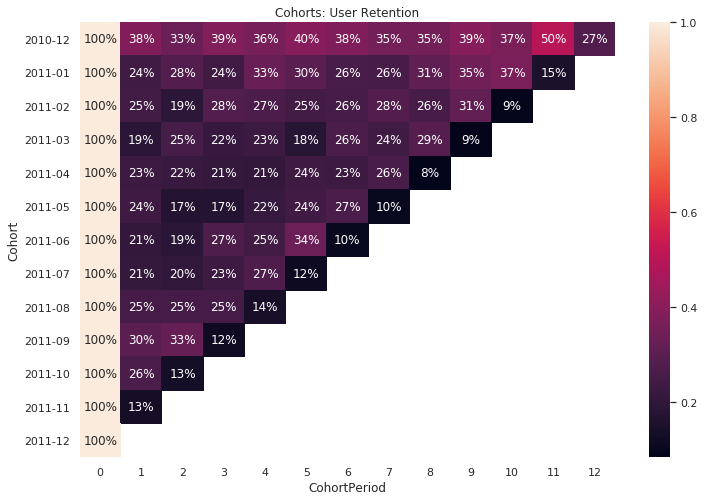

In [19]:
cohorts_group = df_merged.groupby(['Cohort', 'InvoiceMonth']).agg({'CustomerID': pd.Series.nunique})
cohorts_group.rename(columns={'CustomerID': 'TotalUsers',
                        'InvoiceNo': 'TotalOrders'}, inplace=True)
cohorts_group = cohorts_group.groupby(level=0).apply(cohort_period)
cohorts_group.reset_index(inplace=True)
cohorts_group.set_index(['Cohort', 'CohortPeriod'], inplace=True) 
cohort_group_size = cohorts_group['TotalUsers'].groupby(level=0).first()
user_retention = cohorts_group['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)

sns.set(style='white')
plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');